# Практическая работа 2. Парсинг HTML и консолидация данных

**Студент:** *Давидченко Антонина Сергеевна*

**Вариант:** №5

**Бизнес-кейс:** Анализ популярных рецептов

**Источник:**  Раздел "Горячие блюда из курицы" на сайте1000.menu (3-5 страниц).

**Задача:** Собрать названия рецептов, время приготовления и количество ингредиентов. Найти рецепты с самым быстрым временем приготовления.

## Цель работы

Освоить продвинутые техники сбора данных путем парсинга HTML-страниц с сайта `1000menu`, их последующей консолидации и проведения аналитического исследования для определения структуры спроса на Python-разработчиков с различным опытом работы.

## Теоретическая часть

**Парсинг HTML** — это процесс автоматизированного извлечения данных из веб-страниц. Веб-страницы написаны на языке гипертекстовой разметки (HTML), который имеет древовидную структуру. Парсеры анализируют эту структуру для навигации по ней и извлечения нужной информации (текста, ссылок, атрибутов).

**Ключевые библиотеки:**
- **`requests`**: позволяет отправлять HTTP-запросы к веб-серверу и получать в ответ HTML-код страницы. Это первый шаг любого парсинга — получение исходного кода.
- **`BeautifulSoup`**: создает из полученного HTML-кода объектное представление (дерево объектов), по которому можно легко перемещаться и искать нужные элементы с помощью тегов, классов, идентификаторов и других атрибутов. Это основной инструмент для извлечения данных из HTML.

### Шаг 1. Установка необходимых библиотек

In [1]:
!pip install -q requests beautifulsoup4 pandas matplotlib seaborn

### Шаг 2. парсинг страниц

In [20]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# Базовый URL и заголовки для запросов
BASE_URL = "https://1000.menu/catalog/vtorye-bluda-iz-kuricy"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/91.0.4472.124 Safari/537.36"
}

# Сколько страниц парсим
PAGES_TO_PARSE = 5

# Сюда будем сохранять данные
data = []


In [21]:
for page in range(1, PAGES_TO_PARSE + 1):
    # Формируем правильный URL для страниц
    if page == 1:
        url = BASE_URL
    else:
        url = f"{BASE_URL}/{page}"

    print("Парсим страницу:", url)
    resp = requests.get(url, headers=HEADERS)
    resp.raise_for_status()

    soup = BeautifulSoup(resp.text, 'html.parser')
    recipes = soup.find_all('div', class_='cn-item')

    for rec in recipes:
        # Название
        title_tag = rec.find('a', class_='h5')
        title = title_tag.text.strip() if title_tag else None

        # Время приготовления
        time_tag = rec.find('span', title="Время приготовления блюда")
        time_text = time_tag.text.strip() if time_tag else None
        time_min = parse_time_to_minutes(time_text)

        # Ингредиенты (подсчет через запятую)
        ingredients_tag = rec.find(
            'div', class_='mt-2 text-ellipsed text-ucfirst info add_keywords font-italic font-small'
        )
        ingredients_count = len(ingredients_tag.text.split(',')) if ingredients_tag else None

        # Сохраняем данные
        data.append({
            'title': title,
            'time_str': time_text,
            'time_min': time_min,
            'ingredients_count': ingredients_count
        })

    time.sleep(1)  # чтобы не нагружать сервер


Парсим страницу: https://1000.menu/catalog/vtorye-bluda-iz-kuricy
Парсим страницу: https://1000.menu/catalog/vtorye-bluda-iz-kuricy/2
Парсим страницу: https://1000.menu/catalog/vtorye-bluda-iz-kuricy/3
Парсим страницу: https://1000.menu/catalog/vtorye-bluda-iz-kuricy/4
Парсим страницу: https://1000.menu/catalog/vtorye-bluda-iz-kuricy/5


### Шаг 3. Очистка и преобразование данных


In [3]:
def parse_time_to_minutes(time_str):
    """
    Преобразует строку вида '1 ч 30 мин' или '45 мин' в минуты (int)
    """
    minutes = 0
    if not time_str:
        return None
    time_str = time_str.lower()

    if 'ч' in time_str:
        parts = time_str.split('ч')
        try:
            minutes += int(parts[0].strip()) * 60
        except:
            pass
        if len(parts) > 1 and 'мин' in parts[1]:
            try:
                minutes += int(parts[1].replace('мин','').strip())
            except:
                pass
    elif 'мин' in time_str:
        try:
            minutes += int(time_str.replace('мин','').strip())
        except:
            pass
    return minutes


In [5]:
# Создаем DataFrame
df = pd.DataFrame(data)


print("Собрано рецептов:", len(df))


Собрано рецептов: 280


In [7]:
df.head(10)

,title,time_str,time_min,ingredients_count
0,Курица с хрустящей корочкой запеченная в духов...,2 ч,120.0,8.0
1,Стрипсы КФС из курицы на второе,13 ч,780.0,11.0
2,Жульен с курицей и грибами в тарталетках на вт...,30 мин,30.0,10.0
3,None,None,NaN,NaN
4,Сочные куриные грудки в духовке на второе,1 ч 50 мин,110.0,6.0
5,Куриные бедра на сковороде на второе,1 ч 20 мин,80.0,9.0
6,Курица кусочками в духовке на второе,2 ч 30 мин,150.0,7.0
7,Куриные голени на сковороде на второе,1 ч,60.0,5.0
8,Чкмерули по грузински курица в соусе на второе,1 ч 20 мин,80.0,7.0
9,Лапша вок с курицей и овощами на второе,45 мин,45.0,12.0


In [6]:
if not df.empty:
    min_time = df['time_min'].min()
    fastest = df[df['time_min'] == min_time]

    print(f"\nСамые быстрые рецепты ({min_time} мин):")
    print(fastest[['title','time_str','ingredients_count']])



Самые быстрые рецепты (15.0 мин):
                                               title time_str  \
234  Кесадилья с курицей и сыром в домашних условиях   15 мин   

     ingredients_count  
234                8.0  


### Шаг 4: Анализ и визуализация данных



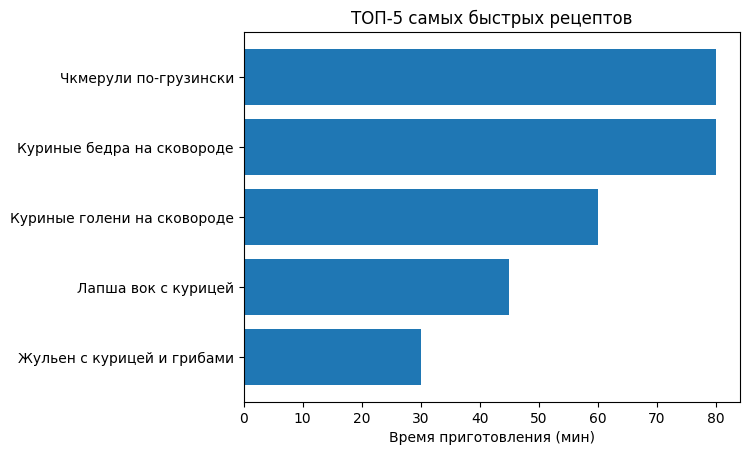

In [17]:
# ТОП-5 самых быстрых рецептов
import pandas as pd
import matplotlib.pyplot as plt

top5_fastest = df.sort_values("time_min").head(5)

plt.figure()
plt.barh(top5_fastest["title"], top5_fastest["time_min"])
plt.xlabel("Время приготовления (мин)")
plt.title("ТОП-5 самых быстрых рецептов")
plt.show()



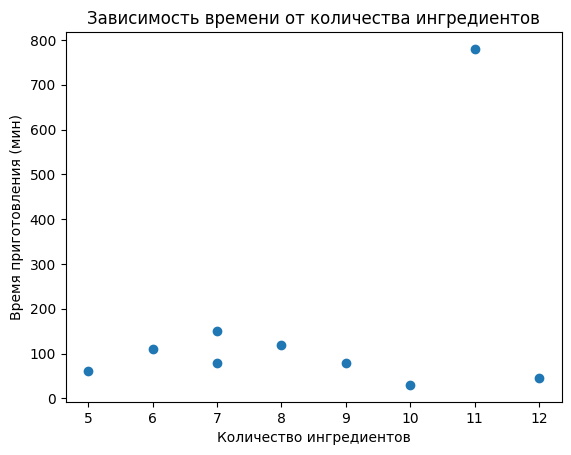

In [18]:
plt.figure()
plt.scatter(df["ingredients_count"], df["time_min"])
plt.xlabel("Количество ингредиентов")
plt.ylabel("Время приготовления (мин)")
plt.title("Зависимость времени от количества ингредиентов")
plt.show()


### Шаг 5: Выводы по анализу

Анализ полученных данных показал,

что большинство рецептов из курицы имеют время приготовления в диапазоне от 30 до 120 минут.

Самым быстрым рецептом является жульен с курицей и грибами, время его приготовления составляет 30 минут. При этом встречаются и значительно более долгие рецепты, время которых может достигать нескольких часов, что указывает на различия в сложности и технологии приготовления. Количество ингредиентов в целом варьируется от 5 до 12 и не всегда напрямую связано с длительностью готовки. Полученные данные позволяют сделать вывод, что при выборе рецепта можно ориентироваться не только на количество ингредиентов, но и на фактическое время приготовления, которое является более показательной характеристикой.